In [22]:
################################
# Basic layout of the notebook #
################################
#
# 1. Load all prerequisites
# 2. Create a noise generator which outputs noise parameterized by some vars.
# 3. Create an adversary which creates adversarial images according to this noise generator.
# 4. Write a loop to display a few images (real image, regular noise, adversarial)
#
# (Unused)
# 4a. Write a loop to display a few images (real image, regular noise, adv 1, 3, 10 steps.)
# 4b. Write a function to display the averages (real image, regular noise, adv 1, 3, 10 steps.)

#########################################
# Basic layout of the problem statement #
#########################################
#
# 1. You have an image x.
# 2. You can modifiy x by adding adversarial noise to x.
# 2a. There are restrictions on the parameterization of the adversarial noise
# 2b. There are restrictions on the scale of the adversarial noise (?)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.model_zoo as model_zoo
import torchvision
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as trn
import skimage as sk

%matplotlib inline

In [4]:
test_transform = trn.Compose([trn.Resize(256), trn.CenterCrop(224), trn.ToTensor()])

mean = torch.FloatTensor(np.array([0.485, 0.456, 0.406]).reshape(1,3,1,1)).cuda()
std = torch.FloatTensor(np.array([0.229, 0.224, 0.225]).reshape(1,3,1,1)).cuda()

test_data = dset.ImageFolder('/home/oliver/git/data/imagenette2/val/', transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True,
                                          num_workers=1, pin_memory=True)

In [5]:
def remove_module(state_dict):
    d = {}
    for key in state_dict:
        d[key[7:]] = state_dict[key]
    return d

net = torch.hub.load('pytorch/vision:v0.10.0', 'resnext101_32x8d', pretrained=True)
'''
net = models.resnet50()
#net.load_state_dict(model_zoo.load_url('https://download.pytorch.org/models/resnet50-19c8e357.pth',
#                                       model_dir='/home/hendrycks/datasets/models'))
session = torch.load('/home/oliver/git/models/deepaugment_and_augmix.pth.tar', map_location=torch.device('cuda'))
state_dict = remove_module(session['state_dict'])
net.load_state_dict(state_dict)
#'''
net.eval()
net.cuda()
cudnn.benchmark = True  # fire on all cylinders

In [6]:
to_np = lambda z: z.to('cpu').detach().numpy()

In [7]:
def hsv2rgb_torch(hsv: torch.Tensor) -> torch.Tensor:
    hsv_h, hsv_s, hsv_l = hsv[:, 0:1], hsv[:, 1:2], hsv[:, 2:3]
    _c = hsv_l * hsv_s
    _x = _c * (- torch.abs(hsv_h * 6. % 2. - 1) + 1.)
    _m = hsv_l - _c
    _o = torch.zeros_like(_c)
    idx = (hsv_h * 6.).type(torch.uint8)
    idx = (idx % 6).expand(-1, 3, -1, -1)
    rgb = torch.empty_like(hsv)
    rgb[idx == 0] = torch.cat([_c, _x, _o], dim=1)[idx == 0]
    rgb[idx == 1] = torch.cat([_x, _c, _o], dim=1)[idx == 1]
    rgb[idx == 2] = torch.cat([_o, _c, _x], dim=1)[idx == 2]
    rgb[idx == 3] = torch.cat([_o, _x, _c], dim=1)[idx == 3]
    rgb[idx == 4] = torch.cat([_x, _o, _c], dim=1)[idx == 4]
    rgb[idx == 5] = torch.cat([_c, _o, _x], dim=1)[idx == 5]
    rgb += _m
    return rgb

def brightness_creator(vars, image):
    '''
    Creates some noise based on some variable. 
    Creation of noise should be batched and enable gradients 
    to flow through it.
    '''
    brightness = vars[0]
    brightness = brightness.unsqueeze(0)
    brightness = torchvision.transforms.functional.gaussian_blur(brightness, kernel_size=11, sigma=5)
    brightness = brightness.squeeze(0)
    image = sk.color.rgb2hsv(image[0].cpu().numpy().transpose((1, 2, 0)))
    image = torch.tensor(image, device="cuda")
    image[:, :, 2] = torch.clamp(image[:, :, 2] + brightness, 0, 1)
    image = image.permute(2, 0, 1)
    image = image.unsqueeze(0)
    image = hsv2rgb_torch(image).clamp(0, 1)
    return image

In [38]:
class BrightnessAdversary(nn.Module):
    def __init__(self, eps=0.05, scale=1, num_steps=10, step_size=0.01):
        super().__init__()
        self.eps = eps
        self.scale = scale
        self.num_steps = num_steps
        self.step_size = step_size

    def forward(self, model, bx, by, x_max):
        """
        :param model: the classifier's forward method
        :param bx: batch of images
        :param by: true labels
        :return: perturbed batch of images
        """
        
        # create initial variables
        brightness_vars = [torch.zeros((224, 224), device="cuda")]
        brightness_vars[0].requires_grad_()
        
        # begin optimizing the inner loop

        #'''
        for i in range(self.num_steps):
            opt = optim.Adam(brightness_vars, lr=0.03) # Pretty hacky!
            opt.zero_grad()

            with torch.enable_grad():
                adv_bx = brightness_creator(brightness_vars, bx.detach())#[:,:,16:-16,16:-16]
                logits = model((adv_bx/x_max - mean)/std)
                loss = -F.cross_entropy(logits, by, reduction='sum')
            
            loss.backward(retain_graph=True)
            #print(brightness_vars[0].grad)
            opt.step()
            
            # clamp variables
            brightness_vars[0] = brightness_vars[0].detach()
            brightness_vars[0] = brightness_vars[0].clone().clamp(-1, 1)
            brightness_vars[0].requires_grad_()
            #print(brightness_vars[0].mean())

        adv_bx = (adv_bx/x_max).clamp(0, 1)
        #'''
        return adv_bx

In [39]:
scale = 0.05
eps = 0.05
adv = BrightnessAdversary(eps, scale)


Clean Image
Loss: 16.44821
Wrong Prediction


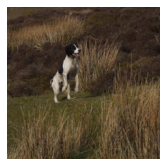


Adversarial Template
Loss: 29.150335
Wrong Prediction


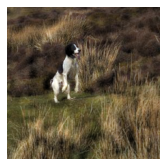


Clean Image
Loss: 13.63968
Wrong Prediction


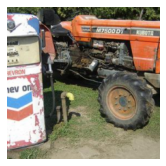


Adversarial Template
Loss: 29.854702
Wrong Prediction


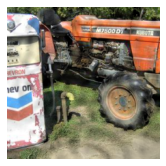


Clean Image
Loss: 14.602597
Wrong Prediction


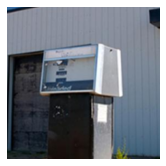


Adversarial Template
Loss: 36.806145
Wrong Prediction


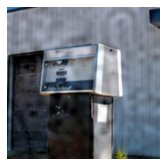

In [40]:
for i, (x, label) in enumerate(test_loader):
    if i < 3:
    
        print('\nClean Image')
        target = torch.LongTensor([label]).cuda()

        x = x.cuda()
        x_max, _ = torch.max(x.view(x.size(0), 3, -1), -1)
        x_max = x_max.view(-1, 3, 1, 1)

        logits = net((x - mean)/std)
        print('Loss:', to_np(F.cross_entropy(logits, target)))
        print(['Wrong Prediction', 'Right Prediction'][int(label == to_np(torch.argmax(logits, 1))[0])])
        
        plt.subplot(1,2,1) # induced for comparable size
        plt.imshow(to_np(x).squeeze().transpose((1,2,0)))
        plt.axis('off')
        plt.show()

        print('\nAdversarial Template')

        adv_x = adv(net, x, target, x_max)
        
        logits = net((adv_x/x_max - mean)/std)
        print('Loss:', to_np(F.cross_entropy(logits, target)))
        print(['Wrong Prediction', 'Right Prediction'][int(label == to_np(torch.argmax(logits, 1))[0])])
        
        plt.subplot(1,2,1)
        plt.imshow(to_np(adv_x).squeeze().transpose((1,2,0)))
        plt.axis('off')
        plt.show()
        
    else:
        break